# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [50]:

import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model
from sklearn import datasets
from scipy.stats import norm
from sklearn.linear_model import Lasso
%matplotlib inline

## Read data 

In [58]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [59]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [60]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

In [ ]:
# uanset hvad så skal vi droppe lande for hvike der ikke er lgdp_initial
# a. så vi starter med at droppe rækkker med NaN i lgdp_initial
dat_test = dat[dat['lgdp_initial'].notnull()]
dat_test # her er 109 lande tilbage
# vi har fået et hint om, at der ofte mangler data i pd1 og pop1
# b så vi tæller antallet af missings for resten af variablene
for col in dat_test.columns:
    print(f'{col}: {dat_test[col].isnull().sum()} missing values')

code: 0 missing values
marketref: 22 missing values
dem: 15 missing values
demCGV: 15 missing values
demBMR: 15 missing values
demreg: 6 missing values
lp_bl: 18 missing values
ls_bl: 18 missing values
lh_bl: 18 missing values
tropicar: 12 missing values
distcr: 12 missing values
distc: 12 missing values
distr: 12 missing values
ginv: 19 missing values
polity: 19 missing values
polity2: 19 missing values
landlock: 8 missing values
yellow: 8 missing values
oilres: 9 missing values
goldm: 9 missing values
iron: 9 missing values
silv: 9 missing values
zinc: 9 missing values
mortality: 57 missing values
imputedmort: 42 missing values
logem4: 37 missing values
excolony: 53 missing values
lt100km: 57 missing values
democ1: 41 missing values
democ00a: 41 missing values
cons00a: 38 missing values
currentinst: 9 missing values
imr95: 58 missing values
leb95: 58 missing values
malfal: 8 missing values
uvdamage: 0 missing values
suitavg: 13 missing values
pdiv: 0 missing values
pdiv_aa: 8 missing

In [65]:
# kan se der også mangler data for gdp-growth. Vi dropper også de rækker, hvor der mangler gdp-growth
dat_test_2 = dat_test[dat_test['gdp_growth'].notnull()]
dat_test_2 # nu er der 102 lande tilbage
for col in dat_test_2.columns:
    print(f'{col}: {dat_test_2[col].isnull().sum()} missing values')

code: 0 missing values
marketref: 18 missing values
dem: 12 missing values
demCGV: 12 missing values
demBMR: 12 missing values
demreg: 3 missing values
lp_bl: 14 missing values
ls_bl: 14 missing values
lh_bl: 14 missing values
tropicar: 9 missing values
distcr: 9 missing values
distc: 9 missing values
distr: 9 missing values
ginv: 16 missing values
polity: 16 missing values
polity2: 16 missing values
landlock: 4 missing values
yellow: 4 missing values
oilres: 5 missing values
goldm: 5 missing values
iron: 5 missing values
silv: 5 missing values
zinc: 5 missing values
mortality: 51 missing values
imputedmort: 35 missing values
logem4: 31 missing values
excolony: 47 missing values
lt100km: 51 missing values
democ1: 35 missing values
democ00a: 35 missing values
cons00a: 32 missing values
currentinst: 5 missing values
imr95: 52 missing values
leb95: 52 missing values
malfal: 6 missing values
uvdamage: 0 missing values
suitavg: 10 missing values
pdiv: 0 missing values
pdiv_aa: 5 missing val

# Augmented Solow regression
initial level of gdp, human capital, capital and labour accumulation

In [72]:
# recreating Barro baseline regression
dat_clean = dat_test_2.copy()
# choose vars to include
vars_to_include = ['lgdp_initial', 'lp_bl', 'ls_bl', 'investment_rate', 'pop_growth', 'leb95', 'gdp_growth']
# drop rows with NaN in any of the chosen vars
dat_clean = dat_clean[vars_to_include].dropna()
dat_clean.shape # now 45 countries left
dat_solow_baseline = dat_clean.copy()
# add constant
oo = np.ones((dat_solow_baseline.shape[0],1))
# we put it in as the last element
dat_solow_baseline = np.hstack([dat_solow_baseline, oo])
# column names
colnames =  ['constant']+ vars_to_include 
# create X and y
X = dat_solow_baseline[:, :-1] # all but last column
y = dat_solow_baseline[:, -1]  # last column
# regress
# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

In [74]:
# format nicely
for k in range(K):
    print(f'{colnames[k]:15s}: {betas[k]:8.4f}')

constant       :   0.0691
lgdp_initial   :  -0.0014
lp_bl          :  -0.0031
ls_bl          :  -0.0034
investment_rate:   8.9536
pop_growth     :   0.0066
leb95          :   1.6593


 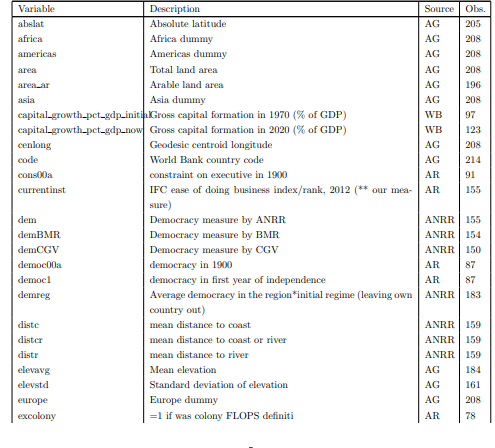 

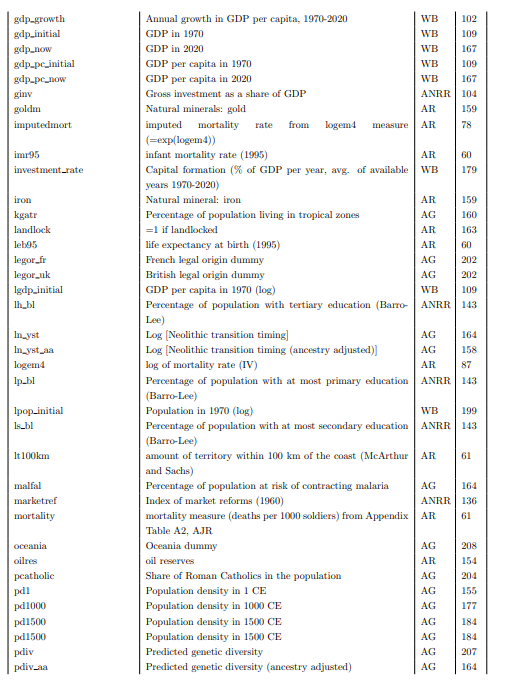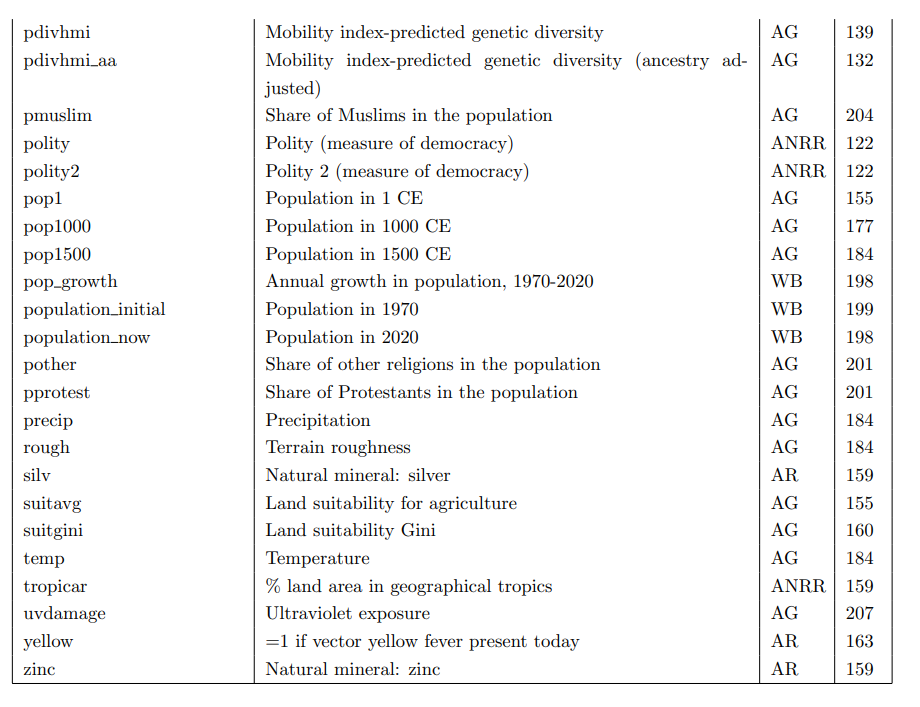

In [66]:
dat_test_2.columns

Index(['code', 'marketref', 'dem', 'demCGV', 'demBMR', 'demreg', 'lp_bl',
       'ls_bl', 'lh_bl', 'tropicar', 'distcr', 'distc', 'distr', 'ginv',
       'polity', 'polity2', 'landlock', 'yellow', 'oilres', 'goldm', 'iron',
       'silv', 'zinc', 'mortality', 'imputedmort', 'logem4', 'excolony',
       'lt100km', 'democ1', 'democ00a', 'cons00a', 'currentinst', 'imr95',
       'leb95', 'malfal', 'uvdamage', 'suitavg', 'pdiv', 'pdiv_aa', 'pdivhmi',
       'pdivhmi_aa', 'pd1', 'pd1000', 'pd1500', 'pd1500.1', 'pop1', 'pop1000',
       'pop1500', 'legor_uk', 'legor_fr', 'temp', 'elevavg', 'elevstd',
       'kgatr', 'precip', 'suitgini', 'area', 'abslat', 'cenlong', 'area_ar',
       'rough', 'ln_yst', 'ln_yst_aa', 'africa', 'europe', 'asia', 'oceania',
       'americas', 'pprotest', 'pcatholic', 'pmuslim', 'pother',
       'population_initial', 'population_now', 'gdp_pc_initial', 'gdp_pc_now',
       'capital_growth_pct_gdp_initial', 'capital_growth_pct_gdp_now',
       'gdp_initial', 'gdp_

# Simple OLS

In [5]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [95]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

In [ ]:
# drop NaN-rows
vs = vv_all['geography'] + vv_all['religion'] + vv_all['institutions'] + vv_all['geneticdiversity']+ vv_all['historical'] + vv_all['danger'] + vv_all['resources'] + vv_all['educ']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
d = dat.loc[I,'lgdp_initial'].values.reshape((-1,1))
Z = dat.loc[I, xs].drop(columns=['lgdp_initial']).values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%
X = np.hstack([d,Z])

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

In [42]:
# Make a function that calculates BRT. Hint: You implemented a version of this last week
# Create a function for standardizing
def standardize(X):
    X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X_stan

# Standardize data
X_stan = standardize(X)
Z_stan = standardize(Z)
d_stan = standardize(d)

def BRT(X_tilde,y):
    (N,p) = X_tilde.shape
    sigma = np.std(y, ddof=1)
    c=1.1
    alpha=0.05

    penalty_BRT= (sigma*c)/np.sqrt(N)*norm.ppf(1-alpha/(2*p))

    return penalty_BRT

# Calculate BRT
penalty_BRTyx = BRT(X_stan,y)

# Run Lasso 
fit_BRTyx = Lasso(penalty_BRTyx, max_iter=10000).fit(X_stan, y)
coefs=fit_BRTyx.coef_

# Calculate residuals
resyx = y-fit_BRTyx.predict(X_stan)

# Calculate Y - Z@gamma (epsilon + alpha*d)
# Hint: You only need the variables given to you in this cell, in addition
# to a standardized data set you made previoously.
resyxz = resyx + d_stan*coefs[0]


C:\Users\annal\AppData\Local\Temp\ipykernel_23972\3820313639.py:4: RuntimeWarning: invalid value encountered in divide
  X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)


ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
X_copy = X.copy()
y_copy = y.copy().reshape(-1,1)

In [110]:
import py_file_p2 as prog

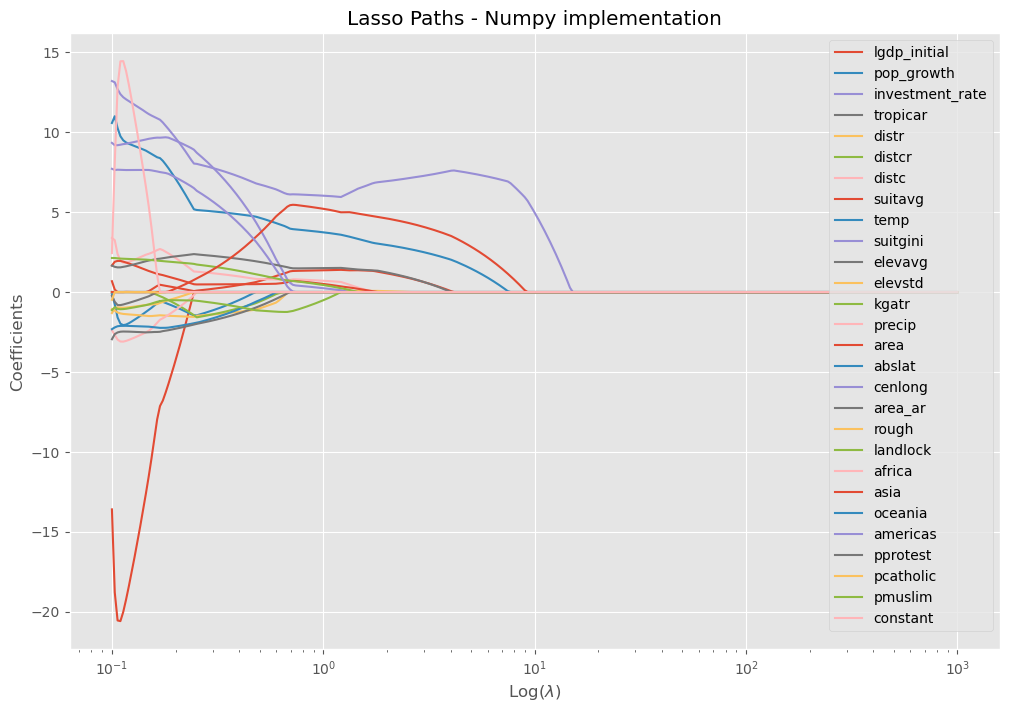

In [112]:
# Initialize variables
m,n = X.shape
initial_theta = np.ones((n,1))
theta_list = list()
lamda = np.logspace(0,4,300)/10 #Range of lambda values

#Run lasso regression for each lambda
for l in lamda:
    theta = prog.coordinate_descent_lasso(initial_theta,X,y,lambda_ = l, num_iters=100)
    theta_list.append(theta)

#Stack into numpy array
theta_lasso = np.stack(theta_list).T

#Plot results
n,_ = theta_lasso.shape
plt.figure(figsize = (12,8))

for i in range(n):
    plt.plot(lamda, theta_lasso[i], label = xs[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')
plt.show()

In [113]:
# run lasso
from sklearn.linear_model import Lasso

# standardize X
def standardize(X):
    X_stan = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_stan
X_stan = standardize(X_copy)

C:\Users\annal\AppData\Local\Temp\ipykernel_27176\3022987491.py:6: RuntimeWarning: invalid value encountered in divide
  X_stan = (X - X.mean(axis=0)) / X.std(axis=0)


In [ ]:
pd.DataFrame(X_stan).round(2)
X_stan = X_stan[:, :-1] # removing the constant column for sklearn
X_stan

array([[ 0.84157067, -0.57683969, -0.48622864, ..., -0.49547972,
         1.44137122, -0.63092088],
       [ 1.79546761, -0.40605336,  0.85842568, ...,  0.47946932,
        -0.20028301, -0.63092088],
       [ 1.58454274, -1.59138944,  0.55835743, ..., -0.31736403,
         1.367232  , -0.61944502],
       ...,
       [ 0.74929218,  0.18645405, -0.09574669, ...,  1.20599383,
        -0.70866625, -0.59936227],
       [-0.25491736,  1.28092969,  2.3711789 , ...,  0.87319873,
        -0.29030921, -0.62805192],
       [-0.39500882,  0.28513343, -1.34534179, ...,  0.38103696,
        -0.60275307, -0.61083813]], shape=(89, 27))

In [ ]:
# run lasso for each lambda
theta_list_skl = list()
for l in lamda:
    lasso = Lasso(alpha=l, fit_intercept=False, max_iter=10000)
    lasso.fit(X_stan, y_copy)
    theta_list_skl.append(lasso.coef_.reshape(-1,1))

# 

In [119]:
# brt
c =1.1
alpha = 0.05
sigma = np.std(y)
n, p = X.shape
from scipy.stats import norm

lamb1 = c * sigma * norm.ppf (1 - alpha /(2* p ))/ np.sqrt ( n )
lamb1

np.float64(0.5215787112281823)

In [122]:
# run lasso for each lambda
theta_list_skl = list()
for l in lamda:
    lasso = Lasso(alpha=l, fit_intercept=False, max_iter=10000)
    lasso.fit(X_stan, y_copy)
    theta_list_skl.append(lasso.coef_.reshape(-1,1))
theta_list_skl

# run lasso for brt lambda

[array([[-0.53551334],
        [-0.29016181],
        [ 0.26217944],
        [-0.11140651],
        [-0.01809227],
        [-0.05826534],
        [-0.        ],
        [ 0.        ],
        [-0.13608063],
        [-0.        ],
        [-0.        ],
        [-0.        ],
        [-0.        ],
        [ 0.        ],
        [ 0.09240928],
        [ 0.        ],
        [ 0.10100511],
        [ 0.05213692],
        [-0.01011788],
        [ 0.        ],
        [-0.24489561],
        [ 0.17004825],
        [-0.        ],
        [ 0.        ],
        [-0.        ],
        [-0.        ],
        [-0.        ]]),
 array([[-0.51423127],
        [-0.29499654],
        [ 0.25754613],
        [-0.10886927],
        [-0.0138409 ],
        [-0.05152503],
        [-0.        ],
        [ 0.        ],
        [-0.12684686],
        [-0.        ],
        [-0.        ],
        [-0.        ],
        [-0.        ],
        [ 0.        ],
        [ 0.08504966],
        [ 0.        ],
        [

In [125]:
# BRT penalty
import scipy
n,p = X_stan.shape
sigma = np.std(y)
c = 1.1 # Fill in
alpha = 0.05 # Fill in
max_term = 1 # Fill in
phi = scipy.stats.norm.ppf(1 - alpha / (2 * p))
penalty_BRT = (c * sigma) * phi / np.sqrt(n)
print('Penalty_BRT: ', round(penalty_BRT,2))

# Implied estimates and selection
fit_BRT = Lasso(alpha=penalty_BRT).fit(X_stan,y) # Fill in
coeff_BRT = fit_BRT.coef_ # Fill in
print('Coefficients: ', np.round(coeff_BRT))

# Selected variables
selected_variables_BRT = (coeff_BRT !=0) # Fill in
#print('Selected variables: ', Xnames[selected_variables_BRT].to_list())


Penalty_BRT:  0.52
Coefficients:  [-0. -0.  0. -0. -0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.
  0.  0. -0.  0. -0. -0. -0. -0. -0.]


In [51]:
# run lasso
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
# we standardize the data to have mean zero and variance one
pipe = make_pipeline(StandardScaler(), Lasso(max_iter=10000))

# define the grid of hyperparameters to search
param_grid = {'lasso__alpha': np.logspace(-4, 1, 100)}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(dat_copy[xs], dat_copy['gdp_growth']*100.)
print("Best penalty = ", grid.best_params_['lasso__alpha'].round(4))
coefs = grid.best_estimator_.named_steps['lasso'].coef_
print("First coefficient =",coefs[0].round(2))



Best penalty =  0.0475
First coefficient = -0.93
